In [14]:
import numpy as np
from datetime import datetime, timezone
from skyfield.api import load, wgs84
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def _normalize_coords_for_ml(lat, lon):
    """Normalizes geographic coordinates into a 3D vector suitable for ML.

    This transforms longitude into a cyclical representation using sin and cos,
    and scales latitude to the [-1, 1] range.

    Args:
        lat (float): Latitude in degrees (-90 to 90).
        lon (float): Longitude in degrees (-180 to 180).

    Returns:
        tuple: A 3-element tuple (normalized_latitude, lon_x, lon_y).
    """
    lat_norm = lat / 90.0
    lon_rad = np.radians(lon)
    lon_x = np.cos(lon_rad)
    lon_y = np.sin(lon_rad)
    return (lat_norm, lon_x, lon_y)

def generate_solar_map(utc_dt: datetime, normalized: bool = True):
    """Generates the Sun's zenith angle map and related geometric data.

    Args:
        utc_dt (datetime): The timezone-aware datetime for the calculation (must be UTC).
        normalized (bool): If True (default), all outputs are normalized for ML.
            If False, outputs are in degrees and kilometers.

    Returns:
        tuple: A tuple containing four items: (map_array, subsolar_coords,
            antipode_coords, distance). The format of the coordinates and
            distance depends on the 'normalized' flag.
            - If normalized, coords are a 3D vector and distance is in AU.
            - If not, coords are (lat, lon) degrees and distance is in km.
    """
    return _generate_map_data(utc_dt, 'sun', normalized)

def generate_lunar_map(utc_dt: datetime, normalized: bool = True):
    """Generates the Moon's zenith angle map and related geometric data.

    Args:
        utc_dt (datetime): The timezone-aware datetime for the calculation (must be UTC).
        normalized (bool): If True (default), all outputs are normalized for ML.
            If False, outputs are in degrees and kilometers.

    Returns:
        tuple: A tuple containing four items: (map_array, sublunar_coords,
            antipode_coords, distance). The format of the coordinates and
            distance depends on the 'normalized' flag.
            - If normalized, coords are a 3D vector and distance is in LD.
            - If not, coords are (lat, lon) degrees and distance is in km.
    """
    return _generate_map_data(utc_dt, 'moon', normalized)

def _generate_map_data(utc_dt: datetime, body_name: str, normalized: bool):
    """
    Helper function to generate a zenith angle map and data for a celestial body.

    Args:
        utc_dt (datetime): The time for the calculation.
        body_name (str): The name of the celestial body ('sun' or 'moon').
        normalized (bool): Controls the output units for the map and distance.

    Returns:
        tuple: A tuple containing the map, sub-point coords, antipode coords, and distance.
    """
    AVG_LUNAR_DISTANCE_KM = 384400.0  # 1 Lunar Distance (LD)

    ts = load.timescale()
    eph = load('de421.bsp')
    earth_body = eph['earth']
    celestial_body = eph[body_name]
    t = ts.from_datetime(utc_dt)

    astrometric = earth_body.at(t).observe(celestial_body)
    subpoint = wgs84.subpoint_of(astrometric)

    sub_lat = subpoint.latitude.degrees
    sub_lon = subpoint.longitude.degrees
    
    antipode_lat = -sub_lat
    antipode_lon = sub_lon + 180
    if antipode_lon > 180:
        antipode_lon -= 360
    
    lat = np.linspace(89.5, -89.5, 180)
    lon = np.linspace(-179.5, 179.5, 360)
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    lat_rad = np.radians(lat_grid)
    lon_rad = np.radians(lon_grid)
    sub_lat_rad = np.radians(sub_lat)
    sub_lon_rad = np.radians(sub_lon)
    
    hour_angle_rad = lon_rad - sub_lon_rad
    cos_z = (np.sin(lat_rad) * np.sin(sub_lat_rad) +
             np.cos(lat_rad) * np.cos(sub_lat_rad) * np.cos(hour_angle_rad))
    cos_z = np.clip(cos_z, -1.0, 1.0)

    if normalized:
        distance = astrometric.distance().au if body_name == 'sun' else astrometric.distance().km / AVG_LUNAR_DISTANCE_KM
        sub_coords = _normalize_coords_for_ml(sub_lat, sub_lon)
        antipode_coords = _normalize_coords_for_ml(antipode_lat, antipode_lon)
        return cos_z, sub_coords, antipode_coords, distance
    else:
        distance = astrometric.distance().km
        sub_coords = (sub_lat, sub_lon)
        antipode_coords = (antipode_lat, antipode_lon)
        zenith_angle_deg = np.degrees(np.arccos(cos_z))
        return zenith_angle_deg, sub_coords, antipode_coords, distance


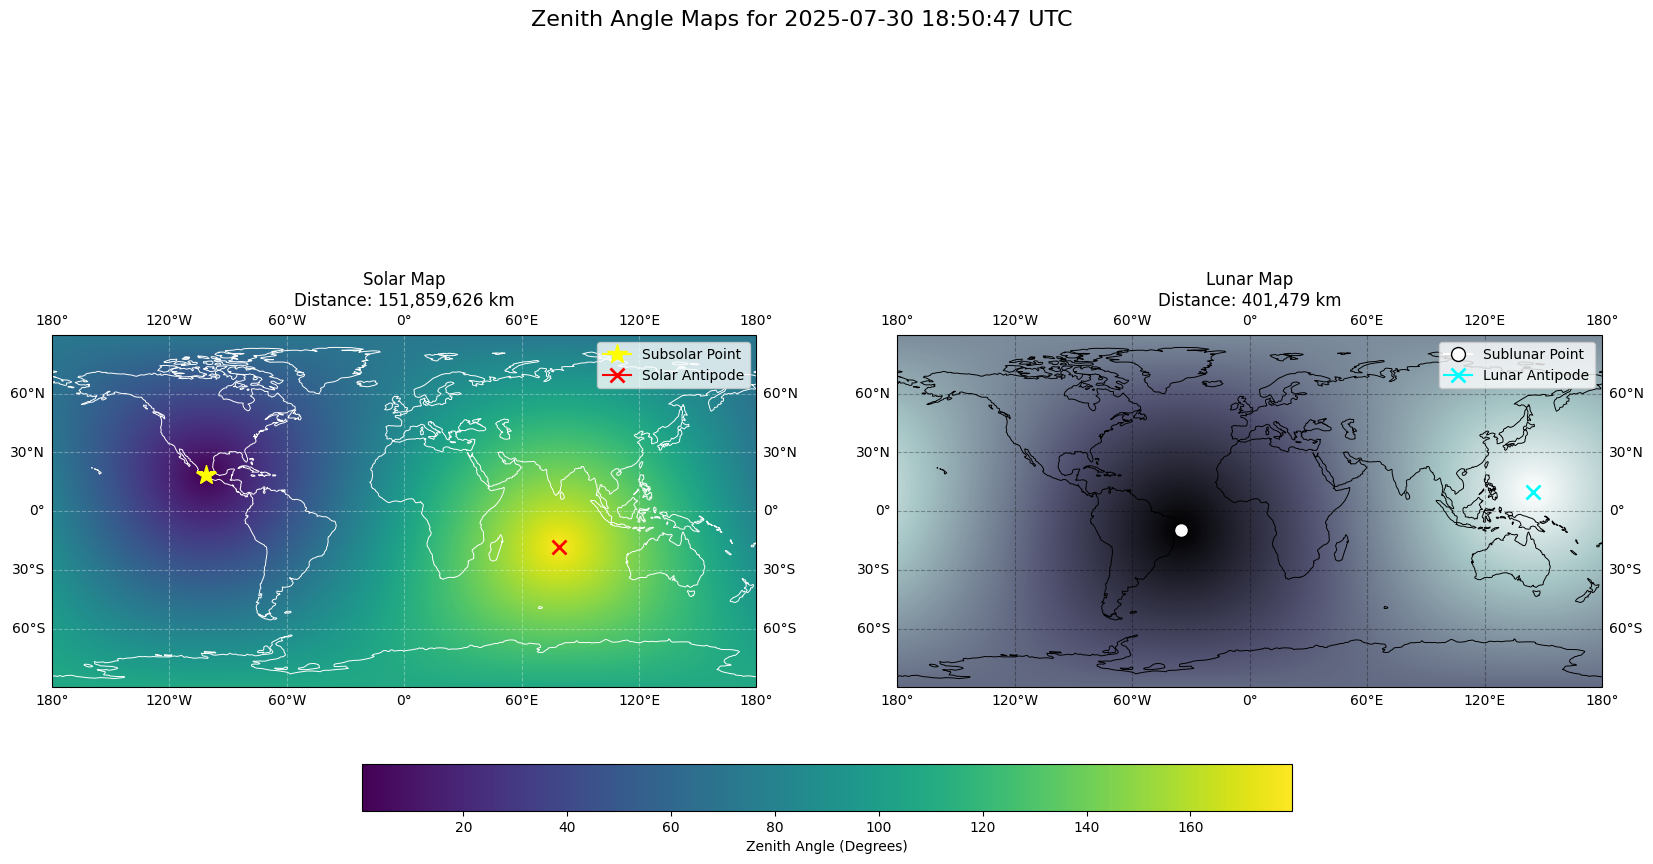

In [16]:
# 1. Get the data for the current time
now_utc = datetime.now(timezone.utc)

# Get data in DEGREES and KM for plotting
solar_map_deg, subsolar_pt, solar_antipode, sun_dist_km = generate_solar_map(now_utc, normalized=False)
lunar_map_deg, sublunar_pt, lunar_antipode, moon_dist_km = generate_lunar_map(now_utc, normalized=False)

# 2. Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10), 
                            subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(f'Zenith Angle Maps for {now_utc.strftime("%Y-%m-%d %H:%M:%S UTC")}', fontsize=16)

# --- Plot 1: Solar Map ---
axes[0].set_global()
axes[0].coastlines(color='white', linewidth=0.7)
im1 = axes[0].imshow(solar_map_deg, extent=(-180, 180, -90, 90), cmap='viridis', transform=ccrs.PlateCarree())
axes[0].plot(subsolar_pt[1], subsolar_pt[0], marker='*', color='yellow', markersize=15, transform=ccrs.Geodetic(), label='Subsolar Point')
axes[0].plot(solar_antipode[1], solar_antipode[0], marker='x', color='red', markeredgewidth=2, markersize=10, transform=ccrs.Geodetic(), label='Solar Antipode')
axes[0].set_title(f'Solar Map\nDistance: {sun_dist_km:,.0f} km')
axes[0].gridlines(draw_labels=True, color='white', alpha=0.3, linestyle='--')
axes[0].legend()

# --- Plot 2: Lunar Map ---
axes[1].set_global()
axes[1].coastlines(color='black', linewidth=0.7)
axes[1].imshow(lunar_map_deg, extent=(-180, 180, -90, 90), cmap='bone', transform=ccrs.PlateCarree())
axes[1].plot(sublunar_pt[1], sublunar_pt[0], marker='o', color='white', markeredgecolor='black', markersize=10, transform=ccrs.Geodetic(), label='Sublunar Point')
axes[1].plot(lunar_antipode[1], lunar_antipode[0], marker='x', color='cyan', markeredgewidth=2, markersize=10, transform=ccrs.Geodetic(), label='Lunar Antipode')
axes[1].set_title(f'Lunar Map\nDistance: {moon_dist_km:,.0f} km')
axes[1].gridlines(draw_labels=True, color='black', alpha=0.3, linestyle='--')
axes[1].legend()

# Add a shared colorbar
fig.colorbar(im1, ax=axes, orientation='horizontal', pad=0.1, shrink=0.6, label='Zenith Angle (Degrees)')

plt.show()